In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from helper import *
import const
from sim import Sim
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.integrate import trapz as integrate
from scipy.integrate import cumtrapz as cumintegrate


In [2]:
time = 1*const.day


In [3]:
rproc = 'strong'

data_rproc = np.load(os.path.join('..', 'rprocess', '%s.npz' % rproc), allow_pickle=True)
data_rproc = SimpleNamespace(**data_rproc)
idx_rproc = np.searchsorted(data_rproc.time, time)
Zmax = 118

if time < data_rproc.time[0]:  print('Warning: time below minimum time in KNe simulations')
if time > data_rproc.time[-1]: print('Warning: time above maximum time in KNe simulations')


In [4]:
Nmax = np.max(data_rproc.ab_iso[idx_rproc])[0][0]
ab_grid = np.zeros((Nmax, Zmax))

for Z in range(Zmax+1):

    A_list, ab_list = data_rproc.ab_iso[idx_rproc, Z]
    for A, ab in zip(A_list, ab_list): ab_grid[A-Z, Z] = ab


In [5]:
with open(os.path.join('..', 'NuDat', 'nndc.csv'), 'r') as f: lines = f.readlines()    
stab_grid = np.full((178, 119), False)
for line in lines[1:]:
    line_split = line.split(',')
    if line_split[4] == 'STABLE': 
        Z = int(line_split[0])
        N = int(line_split[1])
        stab_grid[N, Z] = True


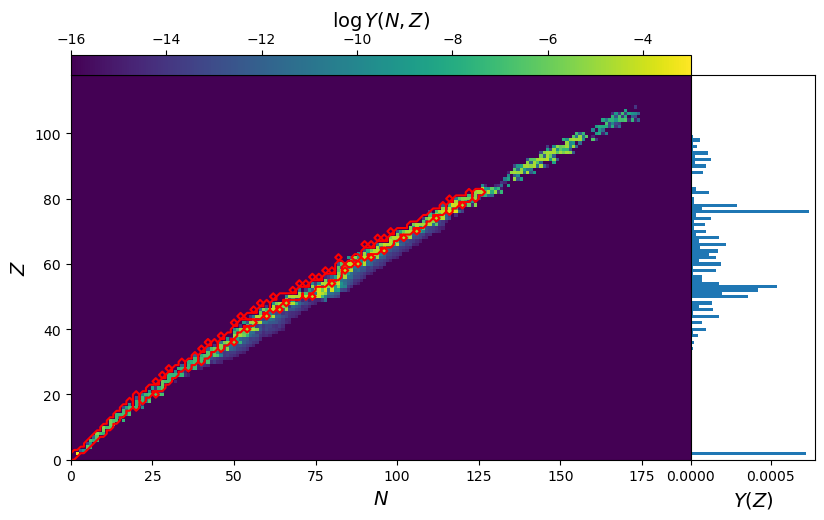

In [6]:
fig, ax1 = plt.subplots(figsize=(8, 8))

im = ax1.imshow(np.log10(ab_grid+1e-20).T, origin='lower', vmin=-16, vmax=-3)

ax1.contour(np.arange(178), np.arange(119), stab_grid.T, colors='red', levels=[0, 1])

ax1.set_xlim(0, 190)
ax1.set_ylim(0, 118)

ax1.set_xlabel(r'$N$', fontsize=14)
ax1.set_ylabel(r'$Z$', fontsize=14)

ax2 = ax1.inset_axes([1, 0, 0.2, 1])
ax2.sharey(ax1)
ax2.barh(np.arange(Zmax+1), data_rproc.ab_elem[idx_rproc], height=1.0, align='center')

ax2.get_yaxis().set_visible(False)
ax2.set_xlabel(r'$Y(Z)$', fontsize=14)

cax = ax1.inset_axes([0, 1, 1, 0.05])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$\log Y(N, Z)$', fontsize=14)
cax.xaxis.set_ticks_position('top')
cax.xaxis.set_label_position('top')


In [7]:
run = 1

data_KNe = np.load(os.path.join('..', 'KNexplosions', 'runhr%d.npz' % run))
data_KNe = SimpleNamespace(**data_KNe)
idx_KNe = np.searchsorted(data_KNe.time, time)

if time < data_KNe.time[0]:  print('Warning: time below minimum time in KNe simulations')
if time > data_KNe.time[-1]: print('Warning: time above maximum time in KNe simulations')

rho = data_KNe.rho_shock[idx_KNe]
temp = data_KNe.temp_shock[idx_KNe]
    
print('Mej: %.3g Msol' % (data_KNe.Mej/const.M_sol))
print('vej: %.3g km/s' % (data_KNe.vej/const.km))
print('n_cgs: %.3g/cc' % (data_KNe.nH_cgm))
print('rho: %.3g g/cc' % rho)
print('T: %.3g K' % temp)
    

Mej: 0.01 Msol
vej: 1.5e+04 km/s
n_cgs: 10/cc
rho: 8.55e-13 g/cc
T: 4.23e+04 K


In [33]:
sim = Sim(ener=10000, rho=rho, do_iso=False)

for Z in range(1, 99):
    
    ab = data_rproc.ab_elem[idx_rproc, Z]
    if ab > 0:
        A_avg = data_rproc.A_avg[idx_rproc, Z]
        sim.add_spec(Z=Z, A=A_avg, ab=ab)

#sim.add_Bturb(Bturb=1e4, q=5/3, fturb=1.0, Lmax=1e17)
#sim.add_Bco(Bmag=1e2, Bhat=np.array([0, 1, 0]), method=2)
        

In [38]:
sim.reset()
for i in range(100):
    sim.step()


Text(0.5, 1.0, '$t=5.27~{\\rm s}$')

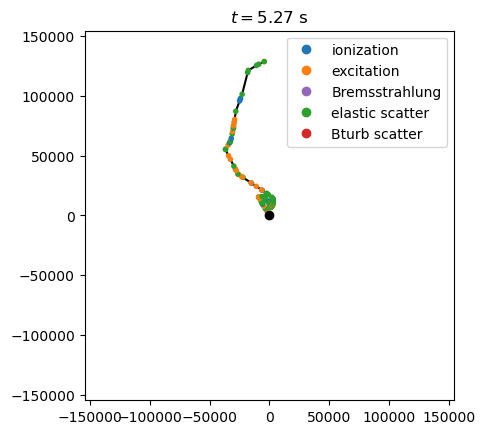

In [39]:
evcat2num = {
    'ionization': 0,
    'excitation': 1,
    'Bremsstrahlung': 4,
    'elastic scatter': 2,
    'Bturb scatter': 3
}

x_list, y_list = np.array(sim.coord_list)[:, X], np.array(sim.coord_list)[:, Y]
color_list = ['C%d'%evcat2num[cat] for cat in sim.ev_cat_list]

plt.plot(0, 0, color='black', marker='o')
plt.scatter(x_list/const.km, y_list/const.km, marker='.', c=color_list)
plt.plot(np.concatenate(([0], x_list))/const.km, np.concatenate(([0], y_list))/const.km, color='black', zorder=-1)

rmax = np.max(np.sqrt(x_list**2+y_list**2))/const.km
plt.xlim(-1.2*rmax, 1.2*rmax)
plt.ylim(-1.2*rmax, 1.2*rmax)

plt.gca().set_aspect(True)

cust_lines = [Line2D([0], [0], marker='o', linestyle='', color='C%d'%num, label=label) for (label, num) in evcat2num.items()]
plt.legend(handles=cust_lines)

plt.title(r'$t=%.2f~{\rm s}$'%sim.time)


Text(0, 0.5, 'number of interactions')

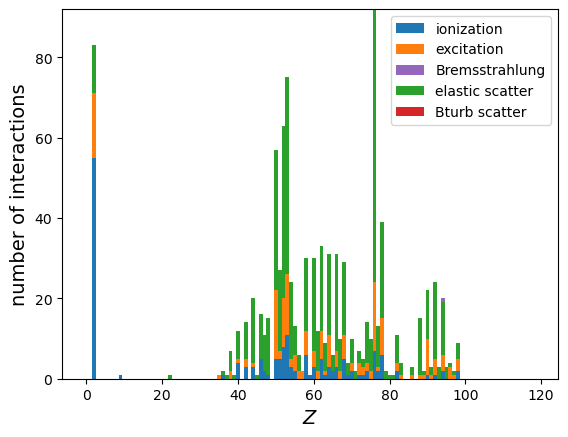

In [31]:
ncat = 5
ev_hist = np.zeros((ncat, Zmax+1), dtype=int)

for cat, Z in zip(sim.ev_cat_list, sim.ev_Z_list):
    ev_hist[evcat2num[cat], Z] += 1
    
for i in range(ncat):
    ev_hist_cum = np.sum(ev_hist[:i], axis=0)
    plt.bar(np.arange(Zmax+1), ev_hist[i], width=1, bottom=ev_hist_cum);
    
cust_lines = [Patch(facecolor='C%d'%num, label=label) for (label, num) in evcat2num.items()]
plt.legend(handles=cust_lines)

plt.xlabel(r'$Z$', fontsize=14)
plt.ylabel(r'number of interactions', fontsize=14)


Text(0, 0.5, '$E$ [${\\rm keV}$]')

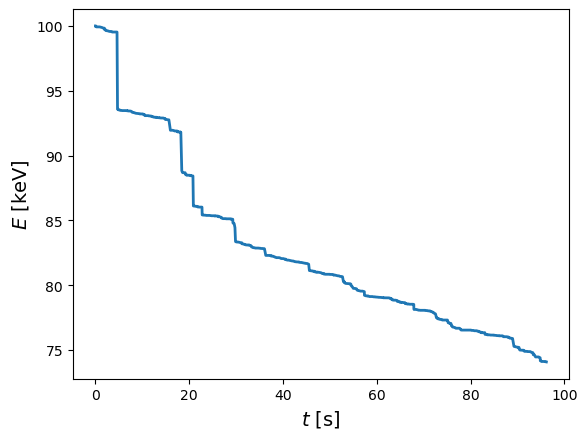

In [32]:
plt.plot(sim.time_list, np.array(sim.ener_list)/1e3, lw=2)

plt.xlabel(r'$t$ [${\rm s}$]', fontsize=14)
plt.ylabel(r'$E$ [${\rm keV}$]', fontsize=14)


In [27]:
sim.ev_label_list

['Os elastic scatter (large angle)',
 'Er ionization (N6)',
 'Mo ionization (N5)',
 'Hf elastic scatter (large angle)',
 'Nd elastic scatter (large angle)',
 'Os elastic scatter (large angle)',
 'Gd elastic scatter (large angle)',
 'Pt elastic scatter (large angle)',
 'I elastic scatter (large angle)',
 'Dy elastic scatter (large angle)',
 'Pd ionization (M4)',
 'U elastic scatter (large angle)',
 'Nd excitation',
 'Os elastic scatter (large angle)',
 'Pd elastic scatter (large angle)',
 'Te elastic scatter (large angle)',
 'Te elastic scatter (large angle)',
 'Ir elastic scatter (large angle)',
 'He ionization (K)',
 'W elastic scatter (large angle)',
 'Th elastic scatter (large angle)',
 'Sb elastic scatter (large angle)',
 'Gd elastic scatter (large angle)',
 'Ce elastic scatter (large angle)',
 'Yb excitation',
 'He elastic scatter (large angle)',
 'Os elastic scatter (large angle)',
 'He ionization (K)',
 'Os ionization (O5)',
 'Pm elastic scatter (large angle)',
 'He excitation',